# Определение перспективного тарифа для телеком-компании

___Описание проекта___:

На основе данных клиентов оператора сотовой связи проанализировать поведение клиентов и поиск оптимального тарифа


___Описание данных___:


Таблица users (информация о пользователях):
 - user_id — уникальный идентификатор пользователя
 - first_name — имя пользователя
 - last_name — фамилия пользователя
 - age — возраст пользователя (годы)
 - reg_date — дата подключения тарифа (день, месяц, год)
 - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент  выгрузки данных)
 - city — город проживания пользователя
 - tarif — название тарифного плана
 - Таблица calls (информация о звонках):
 - id — уникальный номер звонка
 - call_date — дата звонка
 - duration — длительность звонка в минутах
 - user_id — идентификатор пользователя, сделавшего звонок


Таблица messages (информация о сообщениях):
 - id — уникальный номер сообщения
 - message_date — дата сообщения
 - user_id — идентификатор пользователя, отправившего сообщение
 - Таблица internet (информация об интернет-сессиях):
 - id — уникальный номер сессии
 - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
 - session_date — дата интернет-сессии
 - user_id — идентификатор пользователя


Таблица tariffs (информация о тарифах):
 - tariff_name — название тарифа
 - rub_monthly_fee — ежемесячная абонентская плата в рублях
 - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
 - messages_included — количество сообщений в месяц, включённых в абонентскую плату
 - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
 - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
 - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
 - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Загрузка данных

### Звонки

In [1]:
#импорт билиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
print('Данные по звонкам:')
display(calls.info())

Данные по звонкам:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


None

### Интернет

In [3]:
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
display(internet.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB


None

### Сообщения

In [4]:
messages = pd.read_csv('/datasets/messages.csv')
display(messages.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


None

### Тарифы

In [5]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
display(tariffs.head())

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


### Пользователи

In [6]:
users = pd.read_csv('/datasets/users.csv')
display(users.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


None

### Вывод
Данные требуют предобработки:
- Перевод колонок с датами в формат даты
- Округение времени разговора и интернет траффика согласно условиям оператора связи
- Добавление колонок с номером мсяца к которому относятся данные в строке

## Предобработка данных

###  Предобработка данных по звонкам

In [7]:
#переводим колонку с датой в формат даты
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

#округляем звонки в большую сторону
calls['duration'] = calls['duration'].apply(np.ceil).astype('int')

#добавляем колонку с месяцем
calls['month'] = calls['call_date'].dt.month

#группируем таблицу в зависимости от месяца и id пользователя
calls_grouping = calls.groupby(['user_id', 'month'])['duration'].sum().reset_index()

#убираем выбросы
after = len(calls_grouping['duration'])
q1 = calls_grouping['duration'].quantile(0.25)
q3 = calls_grouping['duration'].quantile(0.75)
iqr = q3-q1
calls_grouping = calls_grouping.query('@q1 - 1.5*@iqr < duration and @q3 + 1.5*@iqr > duration')
before = len(calls_grouping['duration'])
print('Удалено выбросов:', after - before, '(', ((after-before)/after*100), '%)')

calls_grouping.head()

#calls_grouping.boxplot('duration')

Удалено выбросов: 65 ( 2.0478890989287963 %)


,user_id,month,duration
0,1000,5,159
1,1000,6,172
2,1000,7,340
3,1000,8,408
4,1000,9,466


### Предобработка данных по использованому интернету

In [8]:
#переводим колонку с датой в формат даты
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

#добавляем колонку с месяцем
internet['month'] = internet['session_date'].dt.month

#группируем таблицу в зависимости от даты и id пользователя
internet_grouping = internet.groupby(['user_id', 'month'])['mb_used'].sum().apply(np.ceil).astype('int').reset_index()

#убираем выбросы
after = len(internet_grouping['mb_used'])
q1 = internet_grouping['mb_used'].quantile(0.25)
q3 = internet_grouping['mb_used'].quantile(0.75)
iqr = q3-q1
internet_grouping = internet_grouping.query('@q1 - 1.5*@iqr < mb_used and @q3 + 1.5*@iqr > mb_used')
before = len(internet_grouping['mb_used'])
print('Удалено выбросов:', after - before, '(', ((after-before)/after*100), '%)')

internet_grouping.head()

Удалено выбросов: 77 ( 2.4039962535123323 %)


,user_id,month,mb_used
0,1000,5,2254
1,1000,6,23234
2,1000,7,14004
3,1000,8,14056
4,1000,9,14569


### Предоработка данных по отправленным сообщениям

In [9]:
#переводим колонку с датой в формат даты
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

#добавляем колонку с месяцем
messages['month'] = messages['message_date'].dt.month

#группируем таблицу в зависимости от даты и id пользователя
messages_grouping = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_grouping.rename({'id': 'massages_count'}, axis=1, inplace=True)

#убираем выбросы
after = len(messages_grouping['massages_count'])
q1 = messages_grouping['massages_count'].quantile(0.25)
q3 = messages_grouping['massages_count'].quantile(0.75)
iqr = q3-q1
messages_grouping = messages_grouping.query('@q1 - 1.5*@iqr < massages_count and @q3 + 1.5*@iqr > massages_count')
before = len(messages_grouping['massages_count'])
print('Удалено выбросов:', after - before, '(', ((after-before)/after*100), '%)')

messages_grouping.head()

Удалено выбросов: 95 ( 3.4965034965034967 %)


,user_id,month,massages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


### Предобработка данных по пользователям

In [10]:
#переводим колонку с датой в формат даты
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')

#добавляем столбцы с месяцами подключния и отключения тарифа
users['reg_month'] = users['reg_date'].dt.month
users['churn_month'] = users['churn_date'].dt.month

users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,reg_month,churn_month
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,5,NaN
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart,11,NaN
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart,6,NaN
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra,8,NaN
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra,5,NaN


### Объединение таблиц

In [11]:
data_month_merged = (calls_grouping
               .merge(internet_grouping, how='outer', on=['user_id','month'])
               .merge(messages_grouping, how='outer', on=['user_id','month'])
               .merge(users, how='outer', on=['user_id'])      
               .merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')           
              )

data_month_merged[['month', 'duration', 'mb_used', 'massages_count']] = (
    data_month_merged[['month', 'duration', 'mb_used', 'massages_count']]
    .fillna(0)
    .astype('int')
)
data_month_merged.head()

,user_id,month,duration,mb_used,massages_count,age,churn_date,city,first_name,last_name,...,reg_month,churn_month,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,1000,5,159,2254,22,52,NaT,Краснодар,Рафаил,Верещагин,...,5,NaN,1000,30720,3000,1950,150,1,1,ultra
1,1000,6,172,23234,60,52,NaT,Краснодар,Рафаил,Верещагин,...,5,NaN,1000,30720,3000,1950,150,1,1,ultra
2,1000,7,340,14004,75,52,NaT,Краснодар,Рафаил,Верещагин,...,5,NaN,1000,30720,3000,1950,150,1,1,ultra
3,1000,8,408,14056,81,52,NaT,Краснодар,Рафаил,Верещагин,...,5,NaN,1000,30720,3000,1950,150,1,1,ultra
4,1000,9,466,14569,57,52,NaT,Краснодар,Рафаил,Верещагин,...,5,NaN,1000,30720,3000,1950,150,1,1,ultra


### Добавление столбцов с выручкой

In [12]:
#считаем выручку за сообщения
data_month_merged['massage_fee'] = (
    (data_month_merged['massages_count']
     - data_month_merged['messages_included']) 
    * data_month_merged['rub_per_message']
)
data_month_merged.loc[data_month_merged['massage_fee'] < 0, 'massage_fee'] = 0

#считаем выручку за интернет
data_month_merged['internet_fee'] = (
    (data_month_merged['mb_used'] 
     - data_month_merged['mb_per_month_included']) 
    / 1024 * data_month_merged['rub_per_gb']
)
data_month_merged.loc[data_month_merged['internet_fee'] < 0, 'internet_fee'] = 0

#считаем выручку за звонки
data_month_merged['duration_fee'] = (
    (data_month_merged['duration'] 
     - data_month_merged['minutes_included']) 
    * data_month_merged['rub_per_minute']
)
data_month_merged.loc[data_month_merged['duration_fee'] < 0, 'duration_fee'] = 0

#считаем общую выручку по месяцам
data_month_merged['total_fee'] = (
    data_month_merged['rub_monthly_fee'] 
    + data_month_merged['massage_fee'] 
    + data_month_merged['internet_fee'] 
    + data_month_merged['duration_fee']
)

data_month_merged.head()

,user_id,month,duration,mb_used,massages_count,age,churn_date,city,first_name,last_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name,massage_fee,internet_fee,duration_fee,total_fee
0,1000,5,159,2254,22,52,NaT,Краснодар,Рафаил,Верещагин,...,3000,1950,150,1,1,ultra,0,0.0,0,1950.0
1,1000,6,172,23234,60,52,NaT,Краснодар,Рафаил,Верещагин,...,3000,1950,150,1,1,ultra,0,0.0,0,1950.0
2,1000,7,340,14004,75,52,NaT,Краснодар,Рафаил,Верещагин,...,3000,1950,150,1,1,ultra,0,0.0,0,1950.0
3,1000,8,408,14056,81,52,NaT,Краснодар,Рафаил,Верещагин,...,3000,1950,150,1,1,ultra,0,0.0,0,1950.0
4,1000,9,466,14569,57,52,NaT,Краснодар,Рафаил,Верещагин,...,3000,1950,150,1,1,ultra,0,0.0,0,1950.0


___Вывод___:
В данных присутствовало небольще количество выбросов, больше всего по количеству отправленных сообщений.


## Анализ данных

### Поведение пользователей в разных тарифах

In [13]:
tariff_pivot = pd.pivot_table(data_month_merged, 
                              index = ['tariff'],
                              aggfunc=['mean', 'std', 'var'],
                              values = ['duration', 'mb_used', 'massages_count']
                             ).astype('int')
tariff_pivot

mean                             std                         \
       duration massages_count mb_used duration massages_count mb_used   
tariff                                                                   
smart       416             32   16087      188             27    5840   
ultra       451             35   16669      288             35    9586   

            var                           
       duration massages_count   mb_used  
tariff                                    
smart     35619            767  34110794  
ultra     83326           1280  91892398

___Вывод___: пользователи тарифа smart менее активны по всем показателям - количество потраченных минут, количество сообщений, объем использванного траффика.
Также на тарифе Smart наблюдается значительно меньший разброс данных

### Сравнение по количеству минут разговора

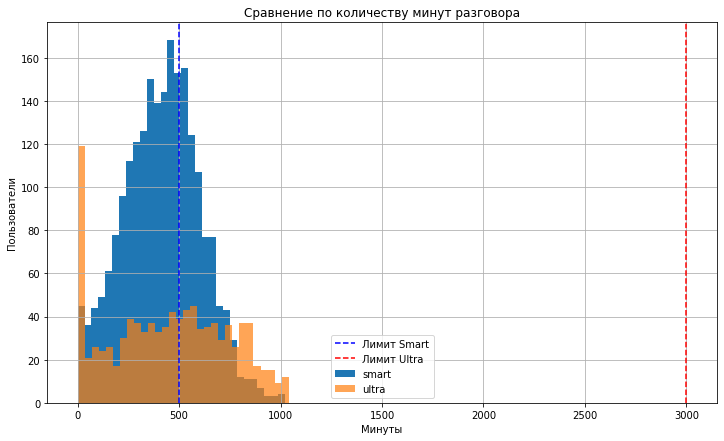

In [14]:
ax = data_month_merged.query('tariff == "smart"').plot(y='duration', kind='hist', bins=30, grid=True, label='smart')
data_month_merged.query('tariff == "ultra"').plot(y='duration', kind='hist', bins=30, grid=True, ax=ax, label='ultra', alpha=0.7, figsize=(12,7), title='Сравнение по количеству минут разговора')
plt.xlabel('Минуты')
plt.ylabel('Пользователи')
plt.axvline(x=tariffs['minutes_included'][0], color='b', label="Лимит Smart", linestyle='dashed')
plt.axvline(x=tariffs['minutes_included'][1], color='r', label="Лимит Ultra", linestyle='dashed')
plt.legend()


___Вывод___: На тарифе Smart пользователи чаще всего расхдуют количество минут в месяц равное лимиту в 500 минут.

Среди пользователей на тарифе Ultra значительно больший разброс по количеству проговоренных минут, но в среднем это количество, значительно меньше чем установленный лимит

### Сравнение по количеству сообщений

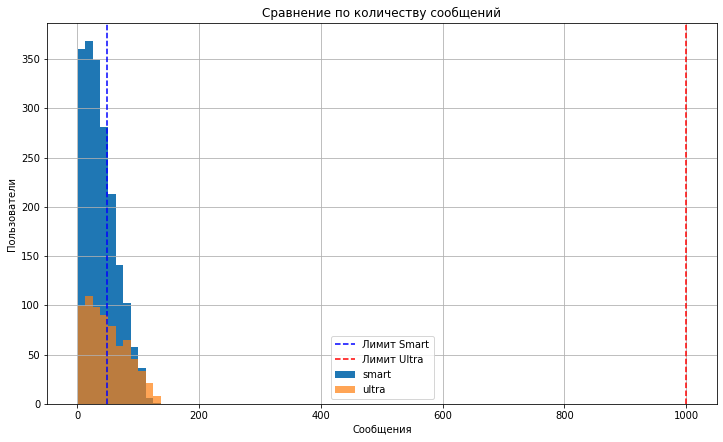

In [15]:
ax = data_month_merged.query('tariff == "smart"').plot(y='massages_count', kind='hist', bins=20, grid=True, label='smart', range=(1,250))
data_month_merged.query('tariff == "ultra"').plot(y='massages_count', kind='hist', bins=20, grid=True, ax=ax, label='ultra', alpha=0.7, range=(1,250), figsize=(12,7), title='Сравнение по количеству сообщений')
plt.xlabel('Сообщения')
plt.ylabel('Пользователи')
plt.axvline(x=tariffs['messages_included'][0], color='b', label="Лимит Smart", linestyle='dashed')
plt.axvline(x=tariffs['messages_included'][1], color='r', label="Лимит Ultra", linestyle='dashed')
plt.legend()

___Вывод___: 

- На тарифе Смарт пользователи часто превышают бесплатный лимит сообщений

- На тариф Ультра пользователи отправляют примерно столько же сообщений как и на тарифе Смарт, но общее количество сообщений значительно меньше чем установленный лимит

### Сравнение по объему трафика

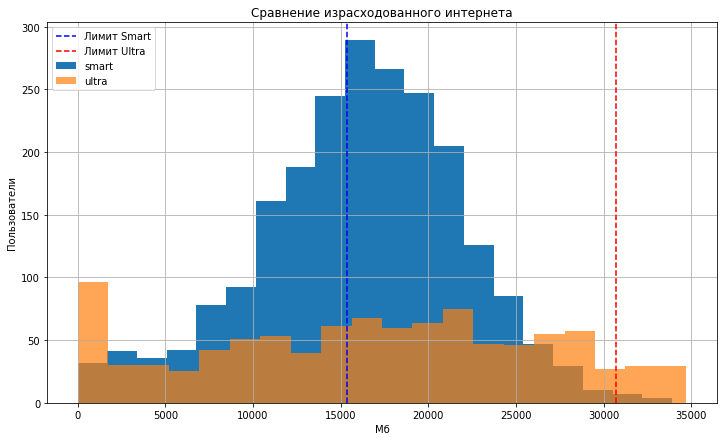

In [16]:
ax = data_month_merged.query('tariff == "smart"').plot(y='mb_used', kind='hist', bins=20, grid=True, label='smart')
data_month_merged.query('tariff == "ultra"').plot(y='mb_used', kind='hist', bins=20, grid=True, ax=ax, label='ultra', alpha=0.7, figsize=(12,7), title='Сравнение израсходованного интернета')
plt.xlabel('Мб')
plt.ylabel('Пользователи')
plt.axvline(x=tariffs['mb_per_month_included'][0], color='b', label="Лимит Smart", linestyle='dashed')
plt.axvline(x=tariffs['mb_per_month_included'][1], color='r', label="Лимит Ultra", linestyle='dashed')

plt.legend()

___Вывод___: 
- На тарифе Смарт чаще всего пользователи превышают бесплатный лимит.

- На тарифе Ультра большинство пользователей укладываються в бесплатный лимит, при объем израсходованного интернета распределяеться значительно более равномерно чем на арифе Смарт.

### Сравнение по выручке

Средняя выручка c 1 пользователя на тарифе Smart: 1213
Средняя выручка c 1 пользователя на тарифе Ultra: 1969


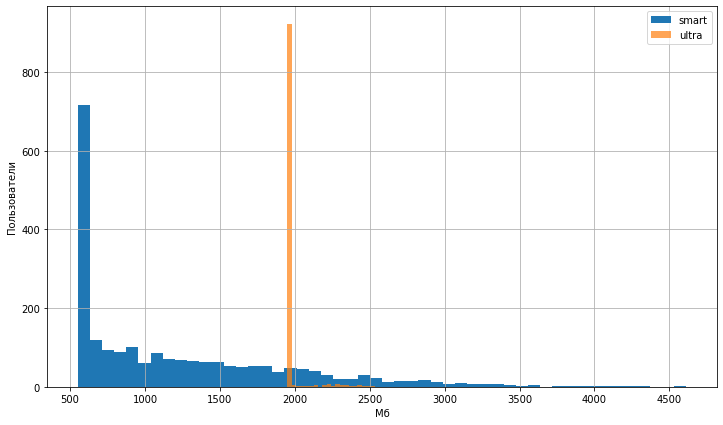

In [17]:
ax = data_month_merged.query('tariff == "smart"').plot(y='total_fee', kind='hist', bins=50, grid=True, label='smart')
data_month_merged.query('tariff == "ultra"').plot(y='total_fee', kind='hist', bins=20, grid=True, ax=ax, label='ultra', alpha=0.7, figsize=(12,7), title='')
plt.xlabel('Мб')
plt.ylabel('Пользователи')
plt.legend()

print('Средняя выручка c 1 пользователя на тарифе Smart:', data_month_merged.query('tariff == "smart"')['total_fee'].mean().astype('int'))
print('Средняя выручка c 1 пользователя на тарифе Ultra:', data_month_merged.query('tariff == "ultra"')['total_fee'].mean().astype('int'))

___Вывод___: Средняя выручка на тарифе Ультра выше чем на тарифе Смарт примерно на 40%, по данным из получнных выборок

## Проверка гипотез

### Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [18]:
fee_pivot = pd.pivot_table(data_month_merged, 
                              index = ['tariff'],
                              aggfunc=['mean', 'median', 'var'],
                              values = ['total_fee']
                             ).astype('int')
fee_pivot.columns=('Среднее', 'Медиана', 'Дисперсия')
fee_pivot

,Среднее,Медиана,Дисперсия
tariff,,,
smart,1213,955,549760
ultra,1969,1950,6981


Нулевая гипотеза звучит как - Средняя выручка пользователей тарифов «Ультра» и «Смарт» равны

Альтернативная гипотеза - Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

In [19]:
sample_smart = data_month_merged.query('tariff == "smart"')['total_fee']
sample_ultra = data_month_merged.query('tariff == "ultra"')['total_fee']

alpha = 0.05
results = st.ttest_ind(sample_smart, sample_ultra, equal_var = True)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение:  2.839784701927119e-194
Отвергаем нулевую гипотезу


### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [20]:
def geo_grouping(row):
    if row == 'Москва':
        return 'Москва'
    else:
        return 'Регионы'

data_month_merged['geo'] = data_month_merged['city'].apply(geo_grouping)

region_pivot = pd.pivot_table(data_month_merged, 
                              index = ['geo'],
                              aggfunc=['mean', 'median', 'var'],
                              values = ['total_fee']
                             ).astype('int')
region_pivot.columns=('Среднее', 'Медиана', 'Дисперсия')
region_pivot
region_pivot


,Среднее,Медиана,Дисперсия
geo,,,
Москва,1469,1675,456480
Регионы,1439,1500,516241


Нулевая гипотеза звучит как - Cредняя выручка пользователей из Москвы и выручка пользователей из других регионов равны

Альтернативная гипотеза - Cредняя выручка пользователей из Москвы и выручка пользователей из других регионов отличаются

In [21]:
sample_moscow = data_month_merged.query('city == "Москва"')['total_fee']
sample_regions = data_month_merged.query('city != "Москва"')['total_fee']

results = st.ttest_ind(sample_regions, sample_moscow, equal_var = True)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не отвергаем нулевую гипотезу')

p-значение:  0.353641834003659
Не отвергаем нулевую гипотезу


## Общий вывод

Пользователи тарифа Ультра ведут себя активнее, но редко превышают бесплатные лимит. Также пользователи тарифа Ультра оличаются большим разбросом по количеству минут разговора и по объему трафика.
Пользователи тарифа Смарт менее активны, вероятно они стараються уложиться в бесплатные лимиты но достаточно часто у них это не получается

Подтвердилась гипотеза о том что средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются
А гипотеза о том средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов, не подтврдилась